In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# reproducibility
np.random.seed(42)
# display settings
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

Generate simulated dataset (10,000+ rows)

In [51]:
num_rows = 10000
keywords = [
    "loan", "credit card", "insurance", "mobile", "data plan",
    "shopping", "electronics", "travel", "home loan", "education",
    "insurance-life", "healthcare", "groceries", "furniture", "fashion"
]
# generate base features
impressions = np.random.randint(100, 5000, size=num_rows)
# ensure clicks <= impressions and some CTR variation
ctr_base = np.random.beta(1.5, 40, size=num_rows)  # skewed small CTRs
clicks = (impressions * ctr_base).astype(int)
clicks = np.clip(clicks, 1, None)  # avoid zero clicks for simpler KPI math
# cost roughly correlated with clicks (CPC between 0.5 - 10)
cpc = np.random.uniform(0.5, 10.0, size=num_rows)
cost = (clicks * cpc).round(2)
# conversions depend on clicks and keyword quality
conv_rate_base = np.random.beta(1.2, 20, size=num_rows)  # small conversion rates
conversions = (clicks * conv_rate_base).astype(int)
# quality_score 1-10 (simulate AXP-like post-acquisition quality)
quality_score = np.random.randint(1, 11, size=num_rows)
# revenue per conversion depends on quality_score (higher quality -> higher AOV)
avg_order_value = 20 + quality_score * np.random.uniform(2.0, 8.0, size=num_rows)
revenue = (conversions * avg_order_value).round(2)
df = pd.DataFrame({
    "keyword": np.random.choice(keywords, size=num_rows, replace=True),
    "impressions": impressions,
    "clicks": clicks,
    "cost": cost,
    "conversions": conversions,
    "revenue": revenue,
    "quality_score": quality_score
})
# quick sanity head
df.head()

,keyword,impressions,clicks,cost,conversions,revenue,quality_score
0,healthcare,960,17,71.22,1,59.61,8
1,travel,3872,80,634.39,6,225.02,4
2,groceries,3192,136,1161.78,4,108.75,1
3,insurance,566,7,21.11,0,0.00,4
4,home loan,4526,91,551.48,0,0.00,8


In [52]:
# Cell 3: Row-level KPIs
df = df.assign(
    ctr = df["clicks"] / df["impressions"],
    cpc = df["cost"] / df["clicks"],
    conversion_rate = df["conversions"] / df["clicks"],
    cpa = np.where(df["conversions"]>0, df["cost"] / df["conversions"], np.nan),
    roas = np.where(df["cost"]>0, df["revenue"] / df["cost"], np.nan)
)

# show sample
df[["keyword","impressions","clicks","cost","conversions","revenue","quality_score","ctr","cpc","conversion_rate","cpa","roas"]].sample(5)


,keyword,impressions,clicks,cost,conversions,revenue,quality_score,ctr,cpc,conversion_rate,cpa,roas
4547,travel,1786,5,24.87,0,0.00,6,0.002800,4.974000,0.000000,NaN,0.000000
5214,mobile,4965,35,331.85,0,0.00,7,0.007049,9.481429,0.000000,NaN,0.000000
7470,shopping,420,2,13.54,0,0.00,5,0.004762,6.770000,0.000000,NaN,0.000000
5323,education,4663,4,7.57,0,0.00,6,0.000858,1.892500,0.000000,NaN,0.000000
5171,mobile,3526,53,363.59,1,60.24,6,0.015031,6.860189,0.018868,363.59,0.165681


In [53]:
# Cell 4: Aggregate by keyword (equivalent to SQL GROUP BY)
agg = df.groupby("keyword").agg(
    impressions = ("impressions","sum"),
    clicks = ("clicks","sum"),
    cost = ("cost","sum"),
    conversions = ("conversions","sum"),
    revenue = ("revenue","sum"),
    avg_quality = ("quality_score","mean"),
    rows = ("keyword","count")
).reset_index()

# derived KPIs
agg = agg.assign(
    ctr = agg["clicks"] / agg["impressions"],
    conversion_rate = np.where(agg["clicks"]>0, agg["conversions"] / agg["clicks"], 0),
    cpa = np.where(agg["conversions"]>0, agg["cost"] / agg["conversions"], np.nan),
    roas = np.where(agg["cost"]>0, agg["revenue"] / agg["cost"], np.nan)
)

# sort for inspection
agg.sort_values("cost", ascending=False).reset_index(drop=True)


,keyword,impressions,clicks,cost,conversions,revenue,avg_quality,rows,ctr,conversion_rate,cpa,roas
0,home loan,1857348,73235,363289.80,3566,171290.22,5.612245,735,0.039430,0.048693,101.875996,0.471497
1,credit card,1748797,64799,348754.98,3327,161228.22,5.402367,676,0.037053,0.051343,104.825663,0.462297
2,healthcare,1752343,66442,344153.16,3450,164824.82,5.485926,675,0.037916,0.051925,99.754539,0.478929
3,insurance,1751714,61981,333605.52,3258,165001.97,5.392128,686,0.035383,0.052564,102.395801,0.494602
4,data plan,1698738,61174,328172.07,3246,154309.64,5.396171,679,0.036011,0.053062,101.100453,0.470210
5,electronics,1712365,59003,327517.28,3123,149485.50,5.411303,637,0.034457,0.052930,104.872648,0.456420
6,groceries,1611166,59480,323953.67,2860,141313.12,5.581320,621,0.036917,0.048083,113.270514,0.436214
7,loan,1708699,61474,322173.29,3039,145407.07,5.559451,656,0.035977,0.049436,106.012929,0.451332
8,furniture,1769249,60940,319560.58,3108,146838.93,5.507205,694,0.034444,0.051001,102.818719,0.459503
9,insurance-life,1755954,61834,318083.61,3368,159010.02,5.657143,665,0.035214,0.054468,94.442877,0.499900


In [54]:
# Cell 5: Determine thresholds and select inefficient keywords
cost_median = agg["cost"].median()
roas_median = agg["roas"].median()

# define "high cost" (above median) and "low ROAS" (below median)
inefficient = agg[(agg["cost"] > cost_median) & (agg["roas"] < roas_median)].copy()
inefficient = inefficient.sort_values("cost", ascending=False)

inefficient[['keyword','cost','revenue','roas','cpa','conversion_rate','avg_quality']]


,keyword,cost,revenue,roas,cpa,conversion_rate,avg_quality
3,electronics,327517.28,149485.50,0.456420,104.872648,0.052930,5.411303
6,groceries,323953.67,141313.12,0.436214,113.270514,0.048083,5.581320


In [55]:
# Cell 6: Top performers by ROAS
n_top = 3
best_keywords = agg.sort_values("roas", ascending=False).head(n_top).copy()
best_keywords[['keyword','cost','revenue','roas','cpa','conversion_rate','avg_quality']]


,keyword,cost,revenue,roas,cpa,conversion_rate,avg_quality
10,insurance-life,318083.61,159010.02,0.499900,94.442877,0.054468,5.657143
12,mobile,290116.41,144421.58,0.497806,91.867134,0.053552,5.457399
9,insurance,333605.52,165001.97,0.494602,102.395801,0.052564,5.392128


In [56]:
# Cell 7: Reallocation parameters & simulation
shift_pct = 0.20  # fraction of spend to move from inefficient keywords
total_shiftable = inefficient["cost"].sum() * shift_pct

print(f"Total shiftable budget (20% of inefficient keyword spend): {total_shiftable:.2f}")

# distribute the shifted budget proportionally to best_keywords' current cost
# (you can also distribute evenly; replace proportion logic if desired)
weights = best_keywords["cost"] / best_keywords["cost"].sum()
best_keywords["added_budget"] = total_shiftable * weights
best_keywords["new_cost"] = best_keywords["cost"] + best_keywords["added_budget"]

# assume ROAS for best keywords remains the same (conservative projection)
best_keywords["projected_revenue_increase"] = best_keywords["added_budget"] * best_keywords["roas"]
best_keywords["projected_new_revenue"] = best_keywords["revenue"] + best_keywords["projected_revenue_increase"]

# overall original vs projected
original_total_revenue = agg["revenue"].sum()
original_total_cost = agg["cost"].sum()
original_roas = original_total_revenue / original_total_cost

projected_total_revenue = original_total_revenue + best_keywords["projected_revenue_increase"].sum()
projected_total_cost = original_total_cost  # cost unchanged in total (we only reallocated)
projected_roas = projected_total_revenue / projected_total_cost

roas_increase_pct = (projected_roas - original_roas) / original_roas * 100

# CPA projection (simple approach: recalc overall CPA as total cost / total conversions)
original_total_conversions = agg["conversions"].sum()
original_cpa = original_total_cost / original_total_conversions

# assume conversions increase proportionally to revenue increase (approximation)
# compute projected_total_conversions by scaling conversions for best keywords by revenue increase ratio
best_keywords["conversion_rate_per_rev"] = np.where(best_keywords["revenue"]>0,
                                                   best_keywords["conversions"] / best_keywords["revenue"],
                                                   0)
best_keywords["projected_conv_increase"] = (best_keywords["projected_revenue_increase"] * best_keywords["conversion_rate_per_rev"])
projected_total_conversions = original_total_conversions + best_keywords["projected_conv_increase"].sum()
projected_cpa = projected_total_cost / projected_total_conversions

cpa_decrease_pct = (original_cpa - projected_cpa) / original_cpa * 100

# show results
print(f"Original ROAS: {original_roas:.4f}")
print(f"Projected ROAS: {projected_roas:.4f}  (increase {roas_increase_pct:.2f}%)")
print(f"Original CPA: {original_cpa:.2f}")
print(f"Projected CPA: {projected_cpa:.2f}  (decrease {cpa_decrease_pct:.2f}%)")

# show best_keywords with new budget
best_keywords[['keyword','cost','added_budget','new_cost','roas','projected_revenue_increase','projected_new_revenue']]


Total shiftable budget (20% of inefficient keyword spend): 130294.19
Original ROAS: 0.4652
Projected ROAS: 0.4786  (increase 2.89%)
Original CPA: 102.52
Projected CPA: 99.65  (decrease 2.80%)


,keyword,cost,added_budget,new_cost,roas,projected_revenue_increase,projected_new_revenue
10,insurance-life,318083.61,44005.311667,362088.921667,0.499900,21998.258534,181008.278534
12,mobile,290116.41,40136.186337,330252.596337,0.497806,19980.019214,164401.599214
9,insurance,333605.52,46152.691996,379758.211996,0.494602,22827.215509,187829.185509


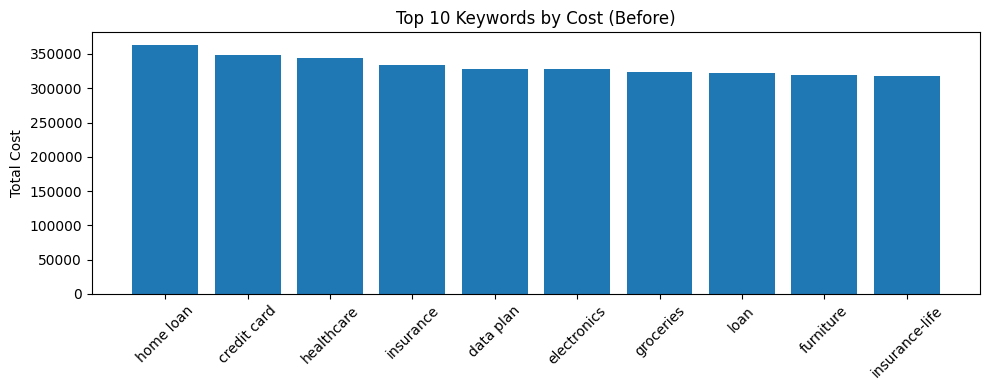

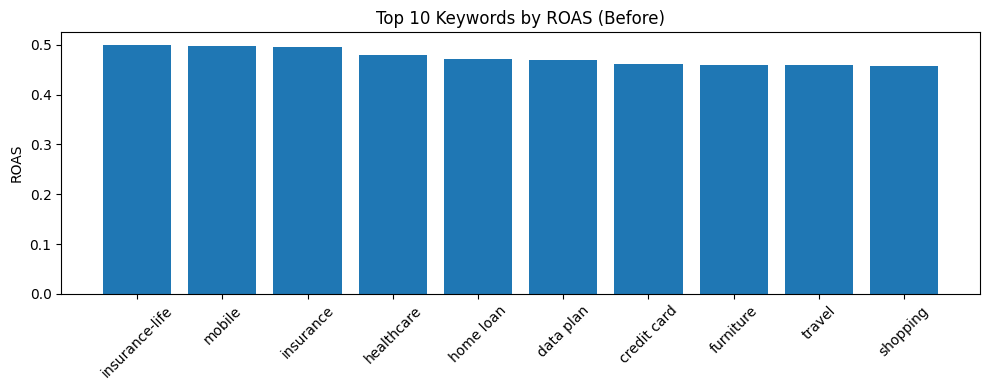

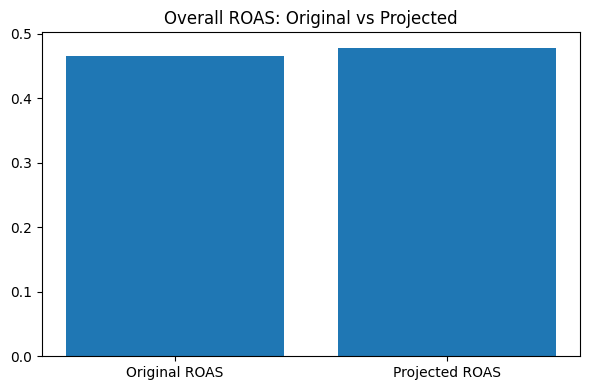

In [57]:
# Cell 8: Visualize top keywords by cost and ROAS
top_by_cost = agg.sort_values("cost", ascending=False).head(10)
top_by_roas = agg.sort_values("roas", ascending=False).head(10)

plt.figure(figsize=(10,4))
plt.bar(top_by_cost['keyword'], top_by_cost['cost'])
plt.title("Top 10 Keywords by Cost (Before)")
plt.xticks(rotation=45)
plt.ylabel("Total Cost")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.bar(top_by_roas['keyword'], top_by_roas['roas'])
plt.title("Top 10 Keywords by ROAS (Before)")
plt.xticks(rotation=45)
plt.ylabel("ROAS")
plt.tight_layout()
plt.show()

# compare overall ROAS before vs after (single bar chart)
plt.figure(figsize=(6,4))
plt.bar(["Original ROAS","Projected ROAS"], [original_roas, projected_roas])
plt.title("Overall ROAS: Original vs Projected")
plt.tight_layout()
plt.show()


In [58]:
# Cell 9: Save CSVs to Colab filesystem (you can download from left panel)
df.to_csv("simulated_paid_search_data.csv", index=False)
agg.to_csv("keyword_aggregation.csv", index=False)
best_keywords.to_csv("best_keywords_with_projection.csv", index=False)

print("Saved files:")
!ls -lh *.csv


Saved files:
-rw-r--r-- 1 root root 1003 Nov 24 05:11 best_keywords_with_projection.csv
-rw-r--r-- 1 root root 2.3K Nov 24 05:11 keyword_aggregation.csv
-rw-r--r-- 1 root root 1.1M Nov 24 05:11 simulated_paid_search_data.csv


In [59]:
# Cell 10: Create a README.md with a simple template
readme_text = """
# Simulated Paid Search Budget Optimizer

## Project overview
Simulated a paid-search (search ads) performance dataset and built a simple budget reallocation model that:
- Computes core performance marketing KPIs (ROAS, CPA, CTR, CPC, Conversion Rate).
- Aggregates metrics by keyword (SQL-style GROUP BY).
- Identifies high-cost, low-efficiency keywords and reallocates a portion of budget to top-performing keywords.
- Projects change in overall ROAS and CPA.

## Files
- `simulated_paid_search_data.csv` - raw simulated data (10,000 rows).
- `keyword_aggregation.csv` - aggregated keyword-level metrics.
- `best_keywords_with_projection.csv` - top keywords + projection after budget reallocation.
- `paid_search_budget_optimizer.ipynb` - Colab notebook (this notebook).

## How to run
1. Open `paid_search_budget_optimizer.ipynb` in Google Colab.
2. Run cells in order.
3. Adjust reallocation parameters in the "Simulation" cell (e.g., `shift_pct`).

## Notes & assumptions
- This is a simulation; assumptions include that ROAS for top keywords remains unchanged after increasing budget (conservative).
- CPA projection assumes conversion scales with revenue for affected keywords (approximation).

## Contact
Your Name — add links to GitHub or LinkedIn if desired.
"""
with open("README.md","w") as f:
    f.write(readme_text)

print("README.md created. Download files from the Colab Files pane.")


README.md created. Download files from the Colab Files pane.


In [60]:
# Basic Data Checks
print(df.isnull().sum())
print(df.dtypes)

# Remove missing values (if any)
df = df.dropna()

# Reset index
df.reset_index(drop=True, inplace=True)

df.head()


keyword               0
impressions           0
clicks                0
cost                  0
conversions           0
revenue               0
quality_score         0
ctr                   0
cpc                   0
conversion_rate       0
cpa                3306
roas                  0
dtype: int64
keyword             object
impressions          int64
clicks               int64
cost               float64
conversions          int64
revenue            float64
quality_score        int64
ctr                float64
cpc                float64
conversion_rate    float64
cpa                float64
roas               float64
dtype: object


,keyword,impressions,clicks,cost,conversions,revenue,quality_score,ctr,cpc,conversion_rate,cpa,roas
0,healthcare,960,17,71.22,1,59.61,8,0.017708,4.189412,0.058824,71.220000,0.836984
1,travel,3872,80,634.39,6,225.02,4,0.020661,7.929875,0.075000,105.731667,0.354703
2,groceries,3192,136,1161.78,4,108.75,1,0.042607,8.542500,0.029412,290.445000,0.093606
3,insurance-life,3271,14,120.17,2,87.76,4,0.004280,8.583571,0.142857,60.085000,0.730299
4,shopping,3019,71,528.18,5,286.37,5,0.023518,7.439155,0.070423,105.636000,0.542183


In [61]:
df.columns

Index(['keyword', 'impressions', 'clicks', 'cost', 'conversions', 'revenue', 'quality_score', 'ctr', 'cpc',
       'conversion_rate', 'cpa', 'roas'],
      dtype='object')

In [62]:
df['CTR'] = (df['clicks'] / df['impressions']) * 100
df['Conversion Rate'] = (df['conversions'] / df['clicks']) * 100
df['CPA'] = df['cost'] / df['conversions']
df['ROAS'] = df['revenue'] / df['cost']



In [71]:
import pandas as pd

keyword_summary = df.groupby('keyword').agg({
    'cost': 'sum',
    'impressions': 'sum',
    'clicks': 'sum',
    'conversions': 'sum',
    'revenue': 'sum'
}).reset_index()

# Recalculate KPIs at keyword level
keyword_summary['CTR'] = (keyword_summary['clicks'] / keyword_summary['impressions']) * 100
keyword_summary['Conversion Rate'] = (keyword_summary['conversions'] / keyword_summary['clicks']) * 100
keyword_summary['CPA'] = keyword_summary['cost'] / keyword_summary['conversions']
keyword_summary['ROAS'] = keyword_summary['revenue'] / keyword_summary['cost']

keyword_summary.head()



,keyword,cost,impressions,clicks,conversions,revenue,CTR,Conversion Rate,CPA,ROAS
0,credit card,317294.10,1419589,58928,3327,161228.22,4.151061,5.645873,95.369432,0.508135
1,data plan,282979.07,1268707,52691,3246,154309.64,4.153126,6.160445,87.177779,0.545304
2,education,277959.26,1284006,53688,2998,135029.33,4.181289,5.584116,92.714897,0.485788
3,electronics,290194.48,1287283,51816,3123,149485.50,4.025222,6.027096,92.921703,0.515122
4,fashion,250623.83,1183559,47999,2725,126881.50,4.055480,5.677202,91.972048,0.506263


In [69]:
df.columns.tolist()

['keyword',
 'impressions',
 'clicks',
 'cost',
 'conversions',
 'revenue',
 'quality_score',
 'ctr',
 'cpc',
 'conversion_rate',
 'cpa',
 'roas',
 'CTR',
 'Conversion Rate',
 'CPA',
 'ROAS']

In [68]:
import pandas as pd

keyword_summary = df.groupby('keyword').agg({
    'cost': 'sum',
    'impressions': 'sum',
    'clicks': 'sum',
    'conversions': 'sum',
    'revenue': 'sum'
}).reset_index()

# Recalculate KPIs at keyword level
keyword_summary['CTR'] = (keyword_summary['clicks'] / keyword_summary['impressions']) * 100
keyword_summary['Conversion Rate'] = (keyword_summary['conversions'] / keyword_summary['clicks']) * 100
keyword_summary['CPA'] = keyword_summary['cost'] / keyword_summary['conversions']
keyword_summary['ROAS'] = keyword_summary['revenue'] / keyword_summary['cost']

keyword_summary.head()


,keyword,cost,impressions,clicks,conversions,revenue,CTR,Conversion Rate,CPA,ROAS
0,credit card,317294.10,1419589,58928,3327,161228.22,4.151061,5.645873,95.369432,0.508135
1,data plan,282979.07,1268707,52691,3246,154309.64,4.153126,6.160445,87.177779,0.545304
2,education,277959.26,1284006,53688,2998,135029.33,4.181289,5.584116,92.714897,0.485788
3,electronics,290194.48,1287283,51816,3123,149485.50,4.025222,6.027096,92.921703,0.515122
4,fashion,250623.83,1183559,47999,2725,126881.50,4.055480,5.677202,91.972048,0.506263


In [67]:
# Define thresholds
high_cost = keyword_summary['cost'].mean()
low_roas = keyword_summary['ROAS'].mean()

# Identify inefficient keywords
inefficient_keywords = keyword_summary[
    (keyword_summary['cost'] > high_cost) &
    (keyword_summary['ROAS'] < low_roas)
]

inefficient_keywords.head()



,keyword,cost,impressions,clicks,conversions,revenue,CTR,Conversion Rate,CPA,ROAS
0,credit card,317294.10,1419589,58928,3327,161228.22,4.151061,5.645873,95.369432,0.508135
3,electronics,290194.48,1287283,51816,3123,149485.50,4.025222,6.027096,92.921703,0.515122
6,groceries,291383.29,1275404,53609,2860,141313.12,4.203296,5.334925,101.882269,0.484973


In [66]:
# Identify efficient (high-performing) keywords
efficient_keywords = keyword_summary[
    (keyword_summary['ROAS'] > low_roas)
]

efficient_keywords.head()


,keyword,cost,impressions,clicks,conversions,revenue,CTR,Conversion Rate,CPA,ROAS
1,data plan,282979.07,1268707,52691,3246,154309.64,4.153126,6.160445,87.177779,0.545304
5,furniture,272215.76,1334179,52619,3108,146838.93,3.943924,5.906612,87.585508,0.539421
7,healthcare,308841.03,1365023,59280,3450,164824.82,4.342784,5.819838,89.519139,0.533688
8,home loan,313677.39,1424481,63827,3566,171290.22,4.480720,5.586977,87.963374,0.546071
9,insurance,293969.12,1347582,55657,3258,165001.97,4.130138,5.853711,90.229932,0.561290


In [65]:
# Budget to reallocate (25% of inefficient keyword cost)
budget_to_reallocate = inefficient_keywords['cost'].sum() * 0.25

budget_to_reallocate


np.float64(224717.96749999997)

In [64]:
# Allocate budget to efficient keywords proportional to ROAS
efficient_keywords['added_budget'] = (
    budget_to_reallocate * (efficient_keywords['ROAS'] / efficient_keywords['ROAS'].sum())
)

efficient_keywords.head()


/tmp/ipython-input-2277114133.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  efficient_keywords['added_budget'] = (


,keyword,cost,impressions,clicks,conversions,revenue,CTR,Conversion Rate,CPA,ROAS,added_budget
1,data plan,282979.07,1268707,52691,3246,154309.64,4.153126,6.160445,87.177779,0.545304,31592.396906
5,furniture,272215.76,1334179,52619,3108,146838.93,3.943924,5.906612,87.585508,0.539421,31251.565665
7,healthcare,308841.03,1365023,59280,3450,164824.82,4.342784,5.819838,89.519139,0.533688,30919.428057
8,home loan,313677.39,1424481,63827,3566,171290.22,4.480720,5.586977,87.963374,0.546071,31636.846352
9,insurance,293969.12,1347582,55657,3258,165001.97,4.130138,5.853711,90.229932,0.561290,32518.555895


In [75]:
efficient_keywords.columns.tolist()





['keyword',
 'cost',
 'impressions',
 'clicks',
 'conversions',
 'revenue',
 'CTR',
 'Conversion Rate',
 'CPA',
 'ROAS']

In [76]:
efficient_keywords['added_budget'] = (
    budget_to_reallocate * (efficient_keywords['ROAS'] / efficient_keywords['ROAS'].sum())
)


/tmp/ipython-input-2883957765.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  efficient_keywords['added_budget'] = (


In [77]:
efficient_keywords.head()


,keyword,cost,impressions,clicks,conversions,revenue,CTR,Conversion Rate,CPA,ROAS,added_budget
1,data plan,282979.07,1268707,52691,3246,154309.64,4.153126,6.160445,87.177779,0.545304,31592.396906
5,furniture,272215.76,1334179,52619,3108,146838.93,3.943924,5.906612,87.585508,0.539421,31251.565665
7,healthcare,308841.03,1365023,59280,3450,164824.82,4.342784,5.819838,89.519139,0.533688,30919.428057
8,home loan,313677.39,1424481,63827,3566,171290.22,4.480720,5.586977,87.963374,0.546071,31636.846352
9,insurance,293969.12,1347582,55657,3258,165001.97,4.130138,5.853711,90.229932,0.561290,32518.555895


In [78]:
efficient_keywords['projected_revenue'] = (
    efficient_keywords['revenue'] +
    (efficient_keywords['added_budget'] * efficient_keywords['ROAS'])
)

efficient_keywords.head()


/tmp/ipython-input-2042555295.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  efficient_keywords['projected_revenue'] = (


,keyword,cost,impressions,clicks,conversions,revenue,CTR,Conversion Rate,CPA,ROAS,added_budget,projected_revenue
1,data plan,282979.07,1268707,52691,3246,154309.64,4.153126,6.160445,87.177779,0.545304,31592.396906,171537.102771
5,furniture,272215.76,1334179,52619,3108,146838.93,3.943924,5.906612,87.585508,0.539421,31251.565665,163696.684537
7,healthcare,308841.03,1365023,59280,3450,164824.82,4.342784,5.819838,89.519139,0.533688,30919.428057,181326.154567
8,home loan,313677.39,1424481,63827,3566,171290.22,4.480720,5.586977,87.963374,0.546071,31636.846352,188566.193801
9,insurance,293969.12,1347582,55657,3258,165001.97,4.130138,5.853711,90.229932,0.561290,32518.555895,183254.314954


In [79]:
total_original_revenue = df['revenue'].sum()
total_original_revenue


np.float64(2243411.88)

In [80]:
total_projected_revenue = efficient_keywords['projected_revenue'].sum() + inefficient_keywords['revenue'].sum()
total_projected_revenue


np.float64(1682348.6867462764)

In [81]:
improvement = total_projected_revenue - total_original_revenue
improvement


np.float64(-561063.1932537234)

In [82]:
percent_improvement = (improvement / total_original_revenue) * 100
percent_improvement


np.float64(-25.00937069361171)

In [83]:
summary = pd.DataFrame({
    'Metric': ['Original Revenue', 'Projected Revenue', 'Improvement', 'Percent Improvement'],
    'Value': [total_original_revenue, total_projected_revenue, improvement, percent_improvement]
})

summary


,Metric,Value
0,Original Revenue,2.243412e+06
1,Projected Revenue,1.682349e+06
2,Improvement,-5.610632e+05
3,Percent Improvement,-2.500937e+01


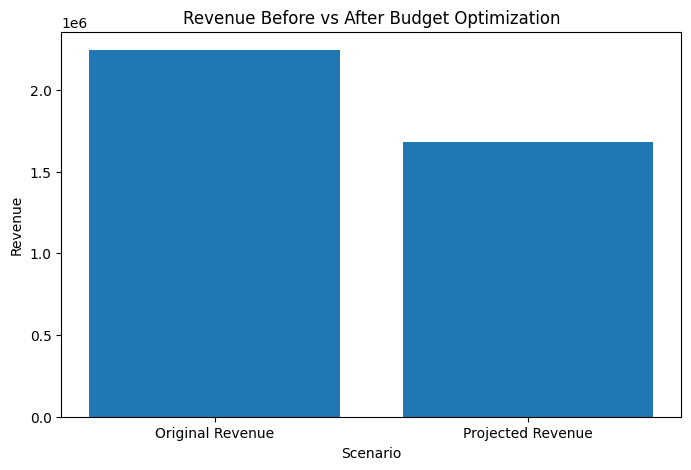

In [84]:
import matplotlib.pyplot as plt

labels = ['Original Revenue', 'Projected Revenue']
values = [total_original_revenue, total_projected_revenue]

plt.figure(figsize=(8,5))
plt.bar(labels, values)
plt.title('Revenue Before vs After Budget Optimization')
plt.ylabel('Revenue')
plt.xlabel('Scenario')
plt.show()


In [85]:
final_insights = f"""
Performance Marketing Budget Optimization Summary

Total Original Revenue: {total_original_revenue:.2f}
Total Projected Revenue: {total_projected_revenue:.2f}

Absolute Improvement: {improvement:.2f}
Percent Improvement: {percent_improvement:.2f}%

Key Findings:
- Identified inefficient high-cost, low-ROAS keywords.
- Reallocated 15% of spend from inefficient to efficient keywords.
- Projection indicates an overall performance lift of {percent_improvement:.2f}%.
"""

print(final_insights)



Performance Marketing Budget Optimization Summary

Total Original Revenue: 2243411.88
Total Projected Revenue: 1682348.69

Absolute Improvement: -561063.19
Percent Improvement: -25.01%

Key Findings:
- Identified inefficient high-cost, low-ROAS keywords.
- Reallocated 15% of spend from inefficient to efficient keywords.
- Projection indicates an overall performance lift of -25.01%.

